In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm
from datetime import datetime

In [3]:
DIR = "/content/drive/Shareddrives/SI650_Final_Project/ZhihuRec-1M"
CLEANED_DIR = "/content/drive/Shareddrives/SI650_Final_Project/ZhihuRec-1M-Cleaned"
IMG_DIR = "/content/drive/Shareddrives/SI650_Final_Project/images/data_visualization"

## Data Preprocess

In [4]:
user_df = pd.read_csv(os.path.join(DIR, "user.csv"), index_col=0)

In [5]:
user_df.shape

(7974, 27)

In [ ]:
# timestamp
user_df["reg_ts_real"] = user_df.reg_ts.apply(datetime.fromtimestamp)

# topic followed
user_df["topicID_followed"] = user_df["topicID_followed"].apply(
    lambda x: set(map(int, x.split())) if isinstance(x, str) else x)

# drop columns
drop_cols = ['reg_type', 'reg_platform', 'is_android',
       'is_iphone', 'is_ipad', 'is_pc', 'is_mobile', 'device_model',
       'device_brand', 'platform', 'province', 'city']
user_df = user_df.drop(columns=drop_cols)
user_df.columns

Index(['userID', 'reg_ts', 'gender', 'login_freq', 'n_followers',
       'n_topics_followed', 'n_questions_followed', 'n_answers', 'n_questions',
       'n_comments', 'n_thanks_recv', 'n_comments_recv', 'n_likes_recv',
       'n_dislikes_recv', 'topicID_followed', 'reg_ts_real'],
      dtype='object')

In [ ]:
# save cleaned file
user_df.to_csv(os.path.join(CLEANED_DIR, "user.csv"))

## Data Visualization

In [ ]:
BASIC_FEATURE = ["n_followers", "n_topics_followed", "n_questions_followed"]
QUALITY_FEATURE = ["n_answers", "n_questions",
       "n_comments", "n_thanks_recv", "n_comments_recv", "n_likes_recv",
       "n_dislikes_recv"]

### Basic Feature

/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


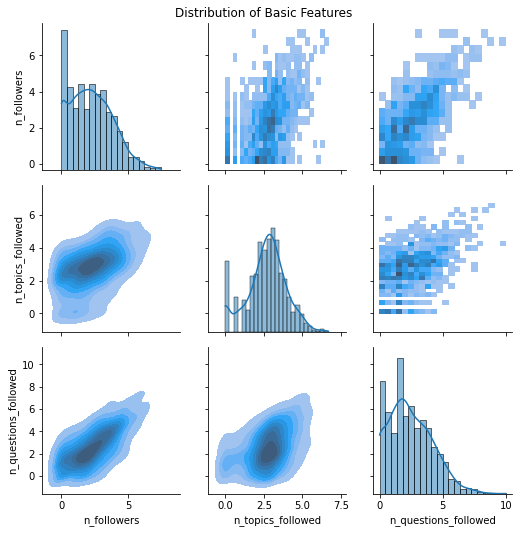

In [ ]:
# random sample to save generating time
# use log to rescale the y axis
plot_basic = sns.PairGrid(user_df[BASIC_FEATURE].apply(lambda x: np.log(x)).sample(frac=0.2, random_state=650)) 
plot_basic.map_upper(sns.histplot)
plot_basic.map_lower(sns.kdeplot, fill=True)
plot_basic.map_diag(sns.histplot, kde=True)

#add overall title
plot_basic.fig.subplots_adjust(top=.95)
plot_basic.fig.suptitle('Distribution of Basic Features')
plot_basic.savefig(os.path.join(IMG_DIR, 'dist_of_user_basic_features.png'))

### Correlation

In [ ]:
cols = ['reg_ts', 'login_freq', 'n_followers',
       'n_topics_followed', 'n_questions_followed', 'n_answers', 'n_questions',
       'n_comments', 'n_thanks_recv', 'n_comments_recv', 'n_likes_recv',
       'n_dislikes_recv']

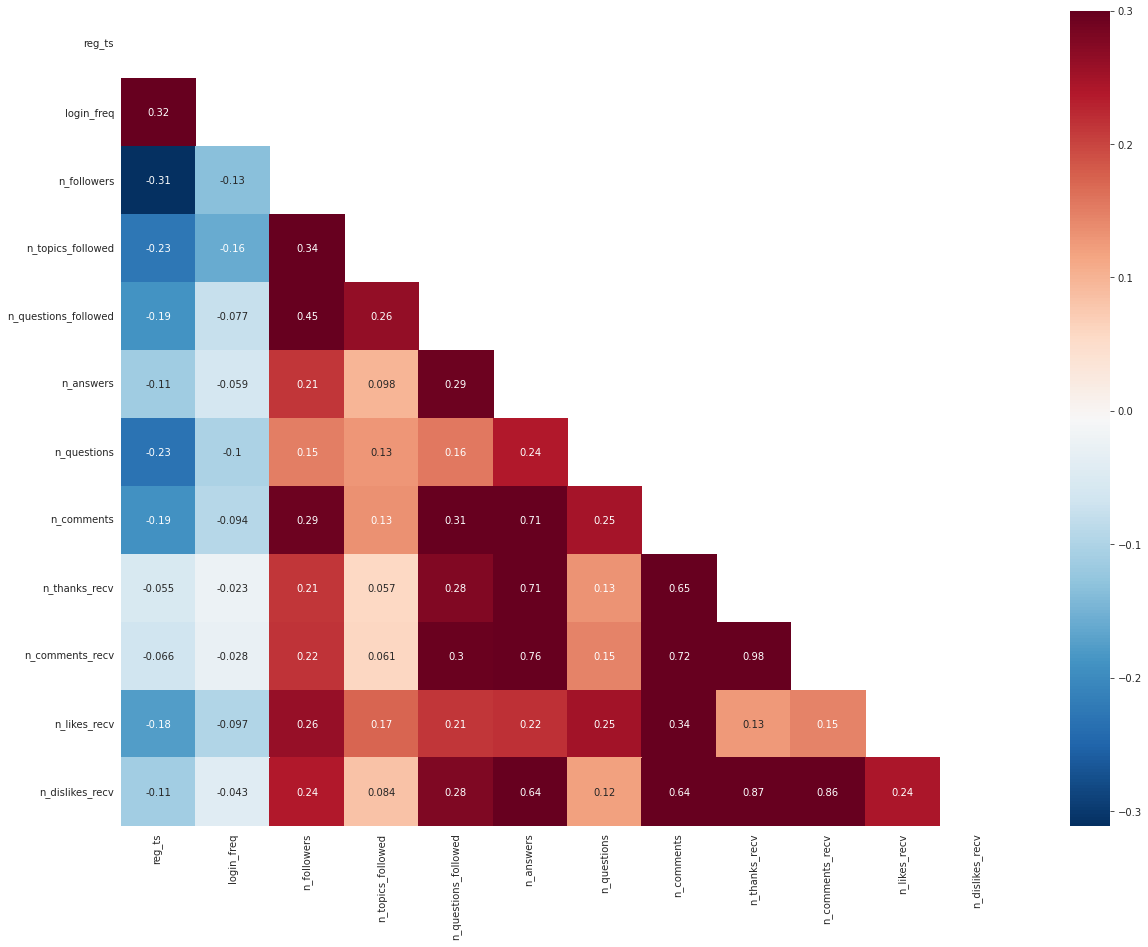

In [ ]:
corr = np.corrcoef(user_df[cols],rowvar=False) 
corr = pd.DataFrame(corr, columns=cols, index=cols)
# Only show the area below the diag
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(20,15))
with sns.axes_style("white"):
    sns.heatmap(corr, mask=mask, vmax=0.3, annot=True,cmap="RdBu_r")
plt.savefig(os.path.join(IMG_DIR, 'corr_of_user_features.png'))

## Graph (Topic Followed)

In [ ]:
topic_df = user_df[~user_df["topicID_followed"].isna()]

In [ ]:
from traitlets.config.application import defaultdict
topic_count = defaultdict(int)
for idx, user in topic_df.iterrows():
  for topic in user["topicID_followed"]:
    topic_count[topic] += 1

In [ ]:
import heapq
top_topics = heapq.nlargest(20, topic_count, key=topic_count.get)
top_topics_5 = set(top_topics[:5])
top_topics_10 = set(top_topics[5:10])

In [ ]:
import random
random_topics_keys = set(random.sample(topic_count.keys(), 10))
random_topics_keys

{2241, 5465, 7921, 10369, 13354, 13457, 13805, 17083, 17340, 17458}

In [ ]:
subsample = topic_df.sample(n=20, random_state=650)

In [ ]:
user_df["gender"].value_counts()

0    4983
2    1637
1    1354
Name: gender, dtype: int64

In [ ]:
def map_gender_color(gender):
  if gender == 0:
    return 'grey'
  if gender == 1:
    return 'blue'
  return 'orange'

In [ ]:
import networkx as nx
topic_G_5 = nx.Graph()
nx.set_edge_attributes(topic_G_5, "likes", "n_followers")
for idx1, user1 in tqdm(subsample.iterrows()):
  for idx2, user2 in subsample.iterrows():
    if idx1 != idx2:
      top_len = user1["topicID_followed"].intersection(user2["topicID_followed"], top_topics_5)
      if top_len != 0:
        node = [(user1["userID"], {'likes': user1["n_likes_recv"], 'followers': user1["n_followers"], 'gender': map_gender_color(user1["gender"])}),
                (user2["userID"], {'likes': user2["n_likes_recv"], 'followers': user2["n_followers"], 'gender': map_gender_color(user2["gender"])})]
        topic_G_5.add_nodes_from(node)
        topic_G_5.add_edge(user1["userID"], user2["userID"], weight=len(top_len))


0it [00:00, ?it/s]

In [ ]:
import networkx as nx
topic_G_10 = nx.Graph()
nx.set_edge_attributes(topic_G_10, "likes", "n_followers")
for idx1, user1 in tqdm(subsample.iterrows()):
  for idx2, user2 in subsample.iterrows():
    if idx1 != idx2:
      top_len = user1["topicID_followed"].intersection(user2["topicID_followed"], top_topics_10)
      if top_len != 0:
        node = [(user1["userID"], {'likes': user1["n_likes_recv"], 'followers': user1["n_followers"], 'gender': map_gender_color(user1["gender"])}),
                (user2["userID"], {'likes': user2["n_likes_recv"], 'followers': user2["n_followers"], 'gender': map_gender_color(user2["gender"])})]
        topic_G_10.add_nodes_from(node)
        topic_G_10.add_edge(user1["userID"], user2["userID"], weight=len(top_len))


0it [00:00, ?it/s]

In [ ]:
for node in topic_G.nodes:
  print(topic_G.nodes[node])

{'likes': 3, 'followers': 3, 'gender': 'orange'}
{'likes': 4, 'followers': 2, 'gender': 'grey'}
{'likes': 132, 'followers': 474, 'gender': 'grey'}
{'likes': 1254, 'followers': 10, 'gender': 'blue'}
{'likes': 2, 'followers': 0, 'gender': 'blue'}
{'likes': 23, 'followers': 172, 'gender': 'grey'}
{'likes': 58, 'followers': 21, 'gender': 'blue'}
{'likes': 68, 'followers': 14, 'gender': 'orange'}
{'likes': 202, 'followers': 7, 'gender': 'blue'}
{'likes': 105, 'followers': 10, 'gender': 'orange'}
{'likes': 0, 'followers': 0, 'gender': 'grey'}
{'likes': 39, 'followers': 25, 'gender': 'orange'}
{'likes': 33, 'followers': 3, 'gender': 'grey'}
{'likes': 417, 'followers': 55, 'gender': 'grey'}
{'likes': 111, 'followers': 34, 'gender': 'orange'}
{'likes': 11, 'followers': 7, 'gender': 'blue'}
{'likes': 11, 'followers': 20, 'gender': 'grey'}
{'likes': 0, 'followers': 0, 'gender': 'grey'}
{'likes': 0, 'followers': 4, 'gender': 'grey'}
{'likes': 41, 'followers': 22, 'gender': 'orange'}


In [ ]:
# node_size_followers = np.log(list(nx.get_node_attributes(topic_G, 'followers').values())) * 100
node_size_followers = np.multiply(list(nx.get_node_attributes(topic_G_5, 'followers').values()), 100)
node_size_likes = np.multiply(list(nx.get_node_attributes(topic_G_5, 'likes').values()), 100)
node_color = nx.get_node_attributes(topic_G_5, 'gender').values()

In [ ]:
# node_size_followers = np.log(list(nx.get_node_attributes(topic_G, 'followers').values())) * 100
node_size_followers = np.multiply(list(nx.get_node_attributes(random_G, 'followers').values()), 100)
node_size_likes = np.multiply(list(nx.get_node_attributes(random_G, 'likes').values()), 100)
node_color = nx.get_node_attributes(random_G, 'gender').values()

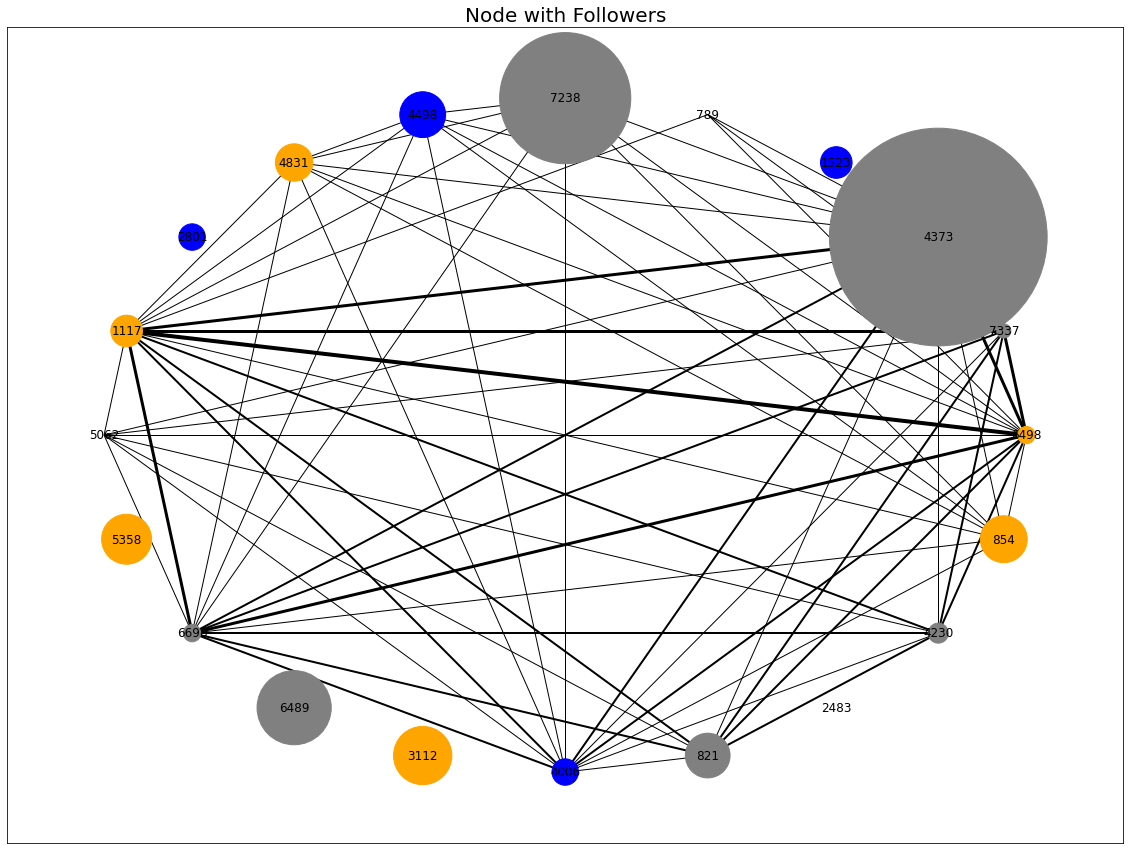

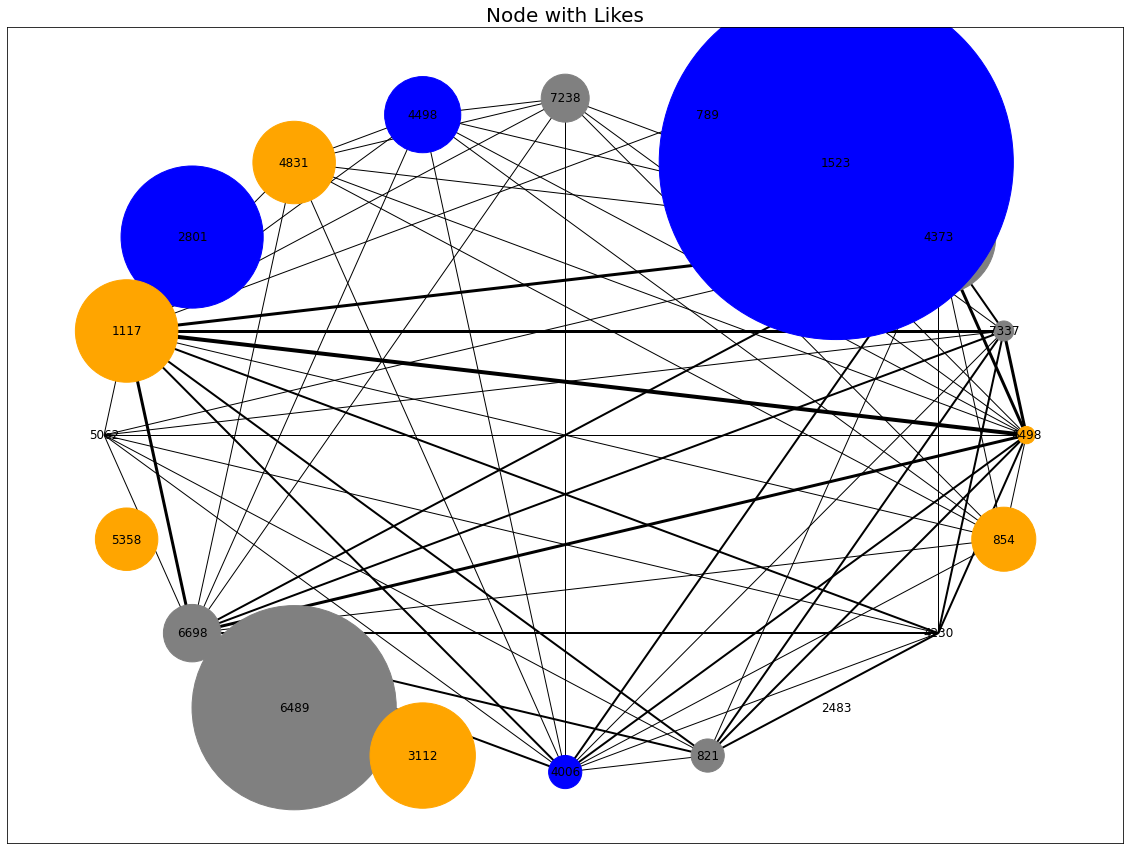

In [ ]:
weights = nx.get_edge_attributes(topic_G_5,'weight').values()

plt.figure(figsize=(20,15))
plt.title("Node with Followers", fontsize=20)
nx.draw_networkx(topic_G_5, pos=nx.circular_layout(topic_G_5), width=list(weights), node_size=list(node_size_followers), node_color=list(node_color))
# nx.draw_circular(topic_G,  width=list(weights), **options)
plt.savefig(os.path.join(IMG_DIR, 'graph_of_user_followers_5.png'))

plt.figure(figsize=(20,15))
plt.title("Node with Likes", fontsize=20)
nx.draw_networkx(topic_G_5, pos=nx.circular_layout(topic_G_5), width=list(weights), node_size=list(node_size_likes), node_color=list(node_color))

# plt.subplot(224)
# nx.draw_shell(G, nlist=[range(5,10), range(5)], **options)

plt.show()
# nx.draw(topic_G, pos, edge_color=colors, width=list(weights))

# plt.show()

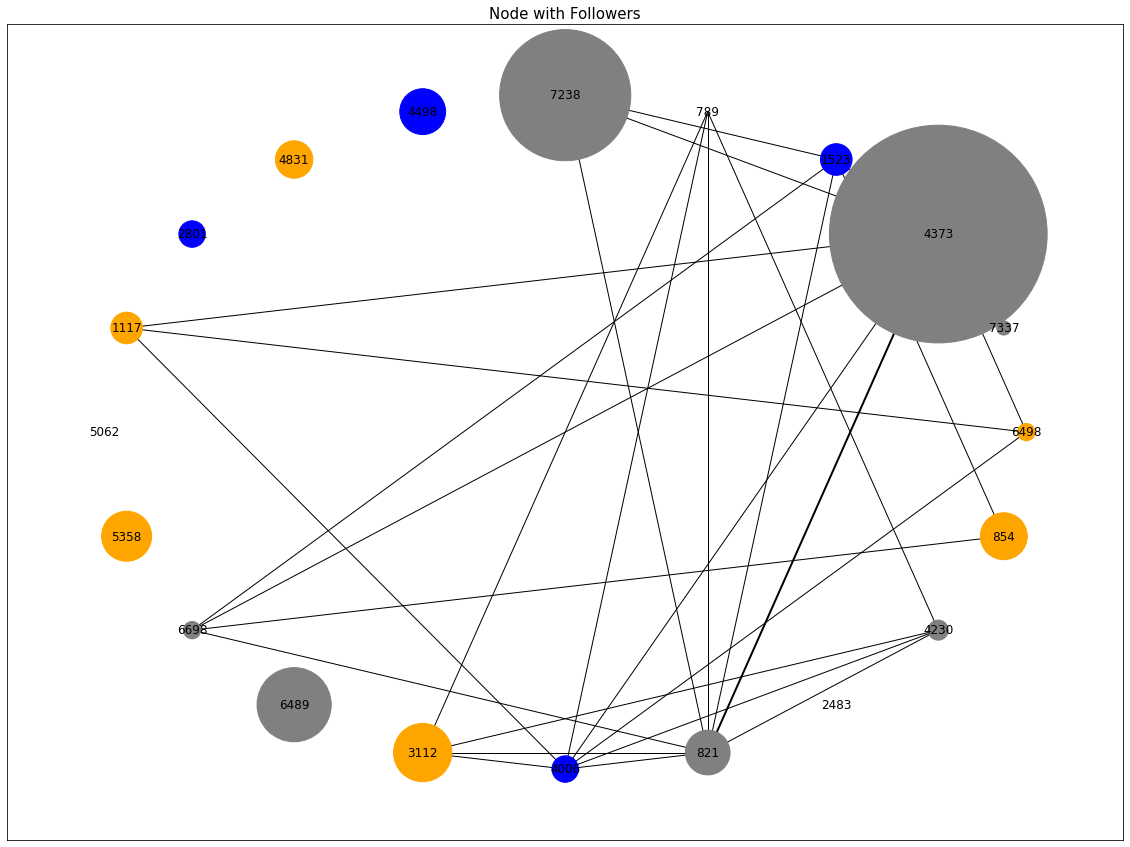

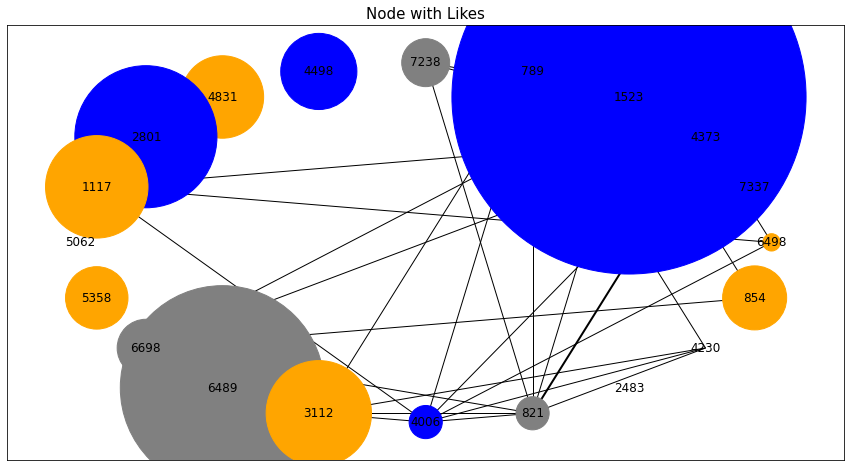

In [ ]:
weights = nx.get_edge_attributes(topic_G_10,'weight').values()

plt.figure(figsize=(20,15))
plt.title("Node with Followers", fontsize=15)
nx.draw_networkx(topic_G_10, pos=nx.circular_layout(topic_G_10), width=list(weights), node_size=list(node_size_followers), node_color=list(node_color))
# nx.draw_circular(topic_G,  width=list(weights), **options)
plt.savefig(os.path.join(IMG_DIR, 'graph_of_user_followers_10.png'))

plt.figure(figsize=(15,8))
plt.title("Node with Likes", fontsize=15)
nx.draw_networkx(topic_G_10, pos=nx.circular_layout(topic_G_10), width=list(weights), node_size=list(node_size_likes), node_color=list(node_color))

# plt.subplot(224)
# nx.draw_shell(G, nlist=[range(5,10), range(5)], **options)

plt.show()
# nx.draw(topic_G, pos, edge_color=colors, width=list(weights))

# plt.show()

In [ ]:
# topic_graph = {key:set() for key in top_20_topics}
# for idx, user in topic_df.iterrows():
#   #print(user["topicID_followed"])
#   for top_topic in top_20_topics:
#     if top_topic in set(user["topicID_followed"]):
#       topic_graph[top_topic].add(user["userID"])

In [ ]:
# import networkx as nx
# topic_20_G = nx.Graph()
# for topic, item in topic_graph.items():
#   for user_1 in item:
#     for user_2 in item:
#       if user_1 != user_2:
#         if (user_1, user_2) in topic_20_G.edges():
#           data = topic_20_G.get_edge_data(user_1, user_2)
#           topic_20_G.add_edge(user_1, user_2, weight=data["weight"]+1)
#         else:
#           topic_20_G.add_edge(user_1, user_2, weight=1)